# Código Clasificación buques mercantes utilizando 4 capas de CNN.


In [66]:
### Conocer version de paquetes y Hardware en uso
#------------------------------------------------------
#------------------------------------------------------
import sys
import tensorflow.keras
import keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import platform

print(f"Plataforma (Software-Hardware): {platform.platform()}")
print(f"Versión de Python {sys.version}")
print(f"Versión de TensorFlow: {tf.__version__}")
print(f"versión de Pandas {pd.__version__}")
print(f"versión de Numpy {np.__version__}")
print(f"versión de Keras {keras.__version__}")
print(f"Versión de Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU está", "Disponible" if gpu else "No Disponible")
#---------------------------------------------------------

Plataforma (Software-Hardware): Windows-10-10.0.19045-SP0
Versión de Python 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
Versión de TensorFlow: 2.13.0
versión de Pandas 2.0.1
versión de Numpy 1.23.5
versión de Keras 2.13.1
Versión de Scikit-Learn 1.2.2
GPU está No Disponible


## Cargamos las librerias necesarias

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


## Cargamos las imagenes

In [68]:
import os
import cv2
import numpy as np
from PIL import Image

altura, longitud = 100, 100

def cargar_y_redimensionar_imagenes(ruta):
    imagenes_redimensionadas = []
    for archivo in os.listdir(ruta):
        archivo_ruta = os.path.join(ruta, archivo)
        # Verificamos si el archivo es una imagen válida antes de abrirlo con OpenCV
        imagen = cv2.imread(archivo_ruta)
        if imagen is not None and len(imagen.shape) == 3 and imagen.shape[2] == 3:
            imagen = cv2.resize(imagen, (altura, longitud))
            imagenes_redimensionadas.append(imagen)
    return imagenes_redimensionadas

# Rutas de los directorios de imágenes
ruta_mercantes = './datos/mercantes'
ruta_otros = './datos/otros'

# Cargar y redimensionar imágenes de mercantes y otros
imagenes_mercantes = cargar_y_redimensionar_imagenes(ruta_mercantes)
imagenes_otros = cargar_y_redimensionar_imagenes(ruta_otros)

# Obtener la cantidad de imágenes en cada directorio
dircount = [len(imagenes_mercantes), len(imagenes_otros)]

print('Imagenes en cada directorio:', dircount)
print('Suma Total de imagenes en subdirectorios:', sum(dircount))

Imagenes en cada directorio: [56, 35]
Suma Total de imagenes en subdirectorios: 91


## Crear etiquetas y clases

**Creamos los labels con valor 1 para mercante y 0 para otros**

In [69]:
# Crear una lista de etiquetas (0 para mercantes, 1 para otros)
etiquetas_mercantes = [0] * len(imagenes_mercantes)
etiquetas_otros = [1] * len(imagenes_otros)

# Combinar las imágenes y etiquetas en un solo conjunto de datos
imagenes = imagenes_mercantes + imagenes_otros
etiquetas = etiquetas_mercantes + etiquetas_otros

## Creamos sets de Entrenamiento y Test

In [70]:
# Convertir a arreglos NumPy
X = np.array(imagenes, dtype=np.uint8)
y = np.array(etiquetas)

# Dividir los datos en conjuntos de entrenamiento y validación (80% para entrenamiento, 20% para validación)
train_X, valid_X, train_label, valid_label = train_test_split(X, y, test_size=0.2, random_state=218) #num de cadete

train_X = train_X / 255.
valid_X = valid_X / 255.

# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs:', nClasses)
print('Output classes:', classes)

train_label_one_hot = to_categorical(train_label, num_classes=nClasses)
valid_label_one_hot = to_categorical(valid_label, num_classes=nClasses)

Total number of outputs: 2
Output classes: [0 1]


## Data augmentation

In [71]:
# Configurar las transformaciones de data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,         # Rango de rotación aleatoria (en grados)
    width_shift_range=0.2,     # Rango de traslación horizontal aleatoria (como fracción del ancho total)
    height_shift_range=0.2,    # Rango de traslación vertical aleatoria (como fracción del alto total)
    shear_range=0.2,           # Rango de cizallamiento (shear) aleatorio
    zoom_range=0.2,            # Rango de zoom aleatorio
    horizontal_flip=True,      # Volteo horizontal aleatorio
    fill_mode='nearest'        # Modo de rellenado para las transformaciones
)

## Creamos la red neuronal de 4 capas

### Dropout (0.3)

In [72]:
from tensorflow.keras.activations import relu, sigmoid

INIT_LR = 0.001#1e-3 

filtrosConv1=32 #despoues de la 1ra conv, la imagen va a tener prof de 32
filtrosConv2=64 #despjes de la 2da, tendra 64
filtrosConv3=128
filtrosConv4=256
tamano_filtro1=(3,3)
tamano_filtro2=(3,3)
tamano_filtro3=(3,3)
tamano_filtro4=(3,3)
tamano_pool=(2,2)

modelo1 = Sequential(name='dropout_0.3')
modelo1.add(Convolution2D(filtrosConv1, tamano_filtro1, padding='same', input_shape=(altura,longitud,3),activation='relu'))
modelo1.add(MaxPooling2D(pool_size=tamano_pool))

#segunda capa de convolucion (), seguida de una capa de max pooling
modelo1.add(Convolution2D(filtrosConv2, tamano_filtro2, padding='same', activation='relu'))
modelo1.add(MaxPooling2D(pool_size=tamano_pool))

#modelo1.add(Convolution2D(filtrosConv3, tamano_filtro3, padding='same', activation='relu'))
#modelo1.add(MaxPooling2D(pool_size=tamano_pool))

#modelo1.add(Convolution2D(filtrosConv4, tamano_filtro4, padding='same', activation='relu'))

#capa que aplana la imagen (1D)
modelo1.add(Flatten())

#capa normal, de 256 neuronas
modelo1.add(Dense(256,activation='relu'))

#capa que apagara el 50% de las neuronas en cada paso, para evitar el overfitting
modelo1.add(Dropout(0.3))

#ultima capa, que son 2 neuronas (una por clase) donde dara % prob da cada clase
modelo1.add(Dense(nClasses,activation='softmax'))

#con Graphviz se puede hacer un diagrama de flujo para ver la logica del sistema
modelo1.summary()

modelo1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),metrics=['accuracy'])

Model: "dropout_0.3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 25, 25, 64)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 40000)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               

## Entrenamos la red


In [73]:
epochs = 150
batch_size = 32

# Crear el generador de datos para el conjunto de entrenamiento con data augmentation
train_data_generator = data_augmentation.flow(train_X, train_label_one_hot, batch_size=batch_size)

## Modifica el train_x para incluir las imagenes del train_data_generator
history1=modelo1.fit(train_data_generator, steps_per_epoch=len(train_X) // batch_size, epochs=epochs, verbose=1, validation_data=(valid_X, valid_label_one_hot))

Epoch 1/150
2/2 [==============================] - 2s 537ms/step - loss: 1.8626 - accuracy: 0.6250 - val_loss: 0.9574 - val_accuracy: 0.6316
Epoch 2/150
2/2 [==============================] - 1s 447ms/step - loss: 1.2510 - accuracy: 0.5625 - val_loss: 1.4157 - val_accuracy: 0.3684
Epoch 3/150
2/2 [==============================] - 1s 300ms/step - loss: 1.3173 - accuracy: 0.3250 - val_loss: 0.7722 - val_accuracy: 0.3684
Epoch 4/150
2/2 [==============================] - 1s 471ms/step - loss: 0.6777 - accuracy: 0.6250 - val_loss: 0.6529 - val_accuracy: 0.6316
Epoch 5/150
2/2 [==============================] - 1s 487ms/step - loss: 0.6422 - accuracy: 0.6750 - val_loss: 0.6432 - val_accuracy: 0.6316
Epoch 6/150
2/2 [==============================] - 1s 284ms/step - loss: 0.7213 - accuracy: 0.5500 - val_loss: 0.6457 - val_accuracy: 0.6316
Epoch 7/150
2/2 [==============================] - 1s 422ms/step - loss: 0.6927 - accuracy: 0.5781 - val_loss: 0.6496 - val_accuracy: 0.6316
Epoch 8/150
2

## Obtenemos las métricas de entrenamiento y validación, luego graficamos



1/1 [==============================] - 0s 149ms/step


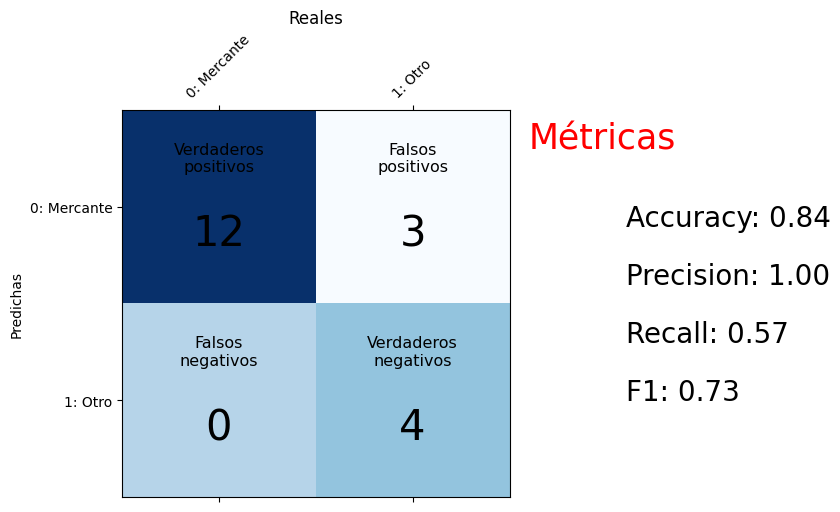

In [74]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

def metricas(clases_reales, clases_predichas):
    matriz_conf=confusion_matrix(clases_reales, clases_predichas)
    accuracy=accuracy_score(clases_reales,clases_predichas)
    precision=precision_score(clases_reales,clases_predichas)
    recall=recall_score(clases_reales,clases_predichas)
    f1=f1_score(clases_reales,clases_predichas)
    return matriz_conf, accuracy, recall, precision, f1

def visualizar_metricas(clases_reales,clases_predichas, titulo):
    #Calculamos metricas con la funcion previa
    matriz, accuracy, recall, precision, f1=metricas(clases_reales,clases_predichas)

    #Graficamos
    plt.figure(figsize=(5,5))
    matriz=pd.DataFrame(matriz,columns=['0: Mercante', '1: Otro'])
    plt.matshow(matriz, cmap="Blues", vmin=0, vmax=10, fignum=1)
    plt.title("Reales")
    plt.ylabel("Predichas")
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.columns)), matriz.columns)
    etiquetas = (("Verdaderos\npositivos", "Falsos\nnegativos"),
                 ("Falsos\npositivos", "Verdaderos\nnegativos"))
    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[i, j]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, etiquetas[i][j],
                     fontsize=11.5, ha="center", va="center")           
    plt.text(1.60, -0.30, titulo, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Accuracy: %0.2f" % accuracy, fontsize=20)
    plt.text(2.1, 0.40, "Precision: %0.2f" % precision, fontsize=20)
    plt.text(2.1, 0.70, "Recall: %0.2f" % recall, fontsize=20)
    plt.text(2.1, 1.00, "F1: %0.2f" % f1, fontsize=20)    
    plt.show()
    print("\n")

print("\n")

predicciones = modelo1.predict(valid_X)
clases_predichas = np.argmax(predicciones, axis=1)
matriz_confusion = confusion_matrix(valid_label, clases_predichas)

visualizar_metricas(valid_label,clases_predichas,'Métricas')


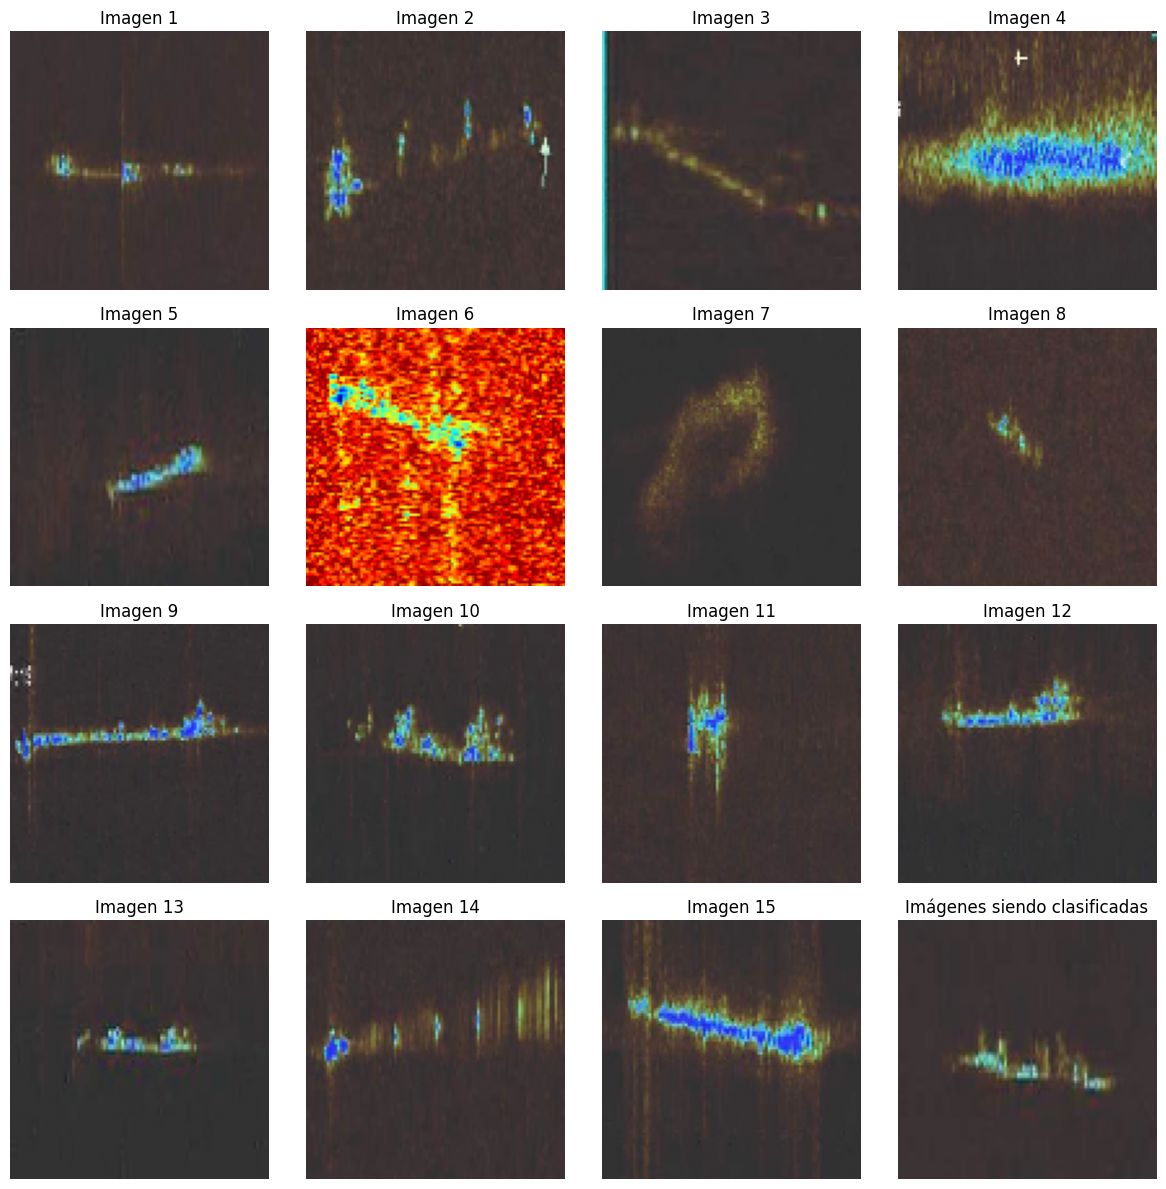

In [84]:
imagenes = valid_X[:16]

# Crea una figura con 4 filas y 4 columnas
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(imagenes[i])
    plt.title(f'Imagen {i+1}')
    plt.axis('off')

plt.title('Imágenes siendo clasificadas')
plt.tight_layout()
plt.show()

## Métricas dropout 0.3

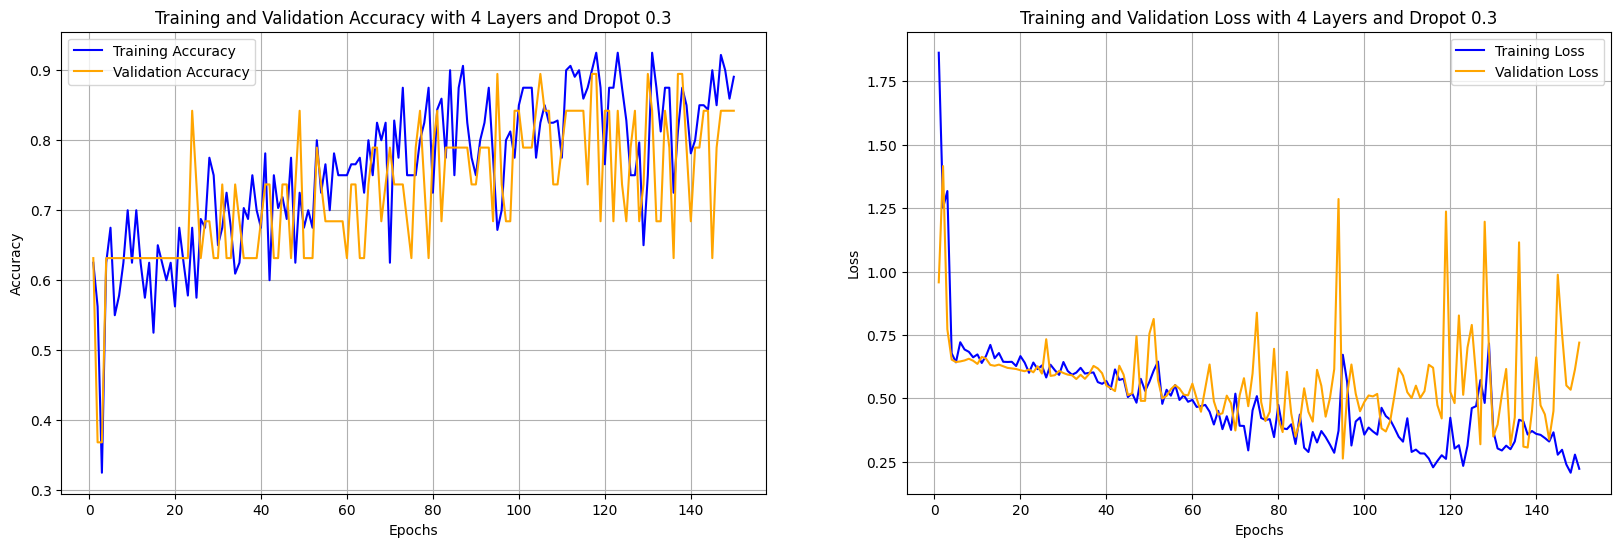

In [76]:
# Obtener las métricas de entrenamiento y validación
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(20,6))

# Gráfica de precisión (accuracy)
plt.subplot(1,2,1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with 4 Layers and Dropot 0.3')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
# Gráfica de pérdida (loss)
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with 4 Layers and Dropot 0.3')
plt.legend()
plt.grid(True)
plt.show()

## Probamos la red

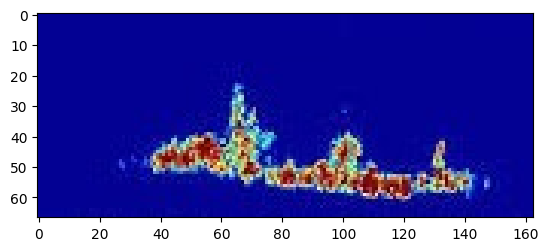

In [77]:
# Muestra de Etiqueta Mercante:
import matplotlib.pyplot as plt
plt.imshow(plt.imread('prueba/1.jpg'))

1/1 [==============================] - 0s 40ms/step


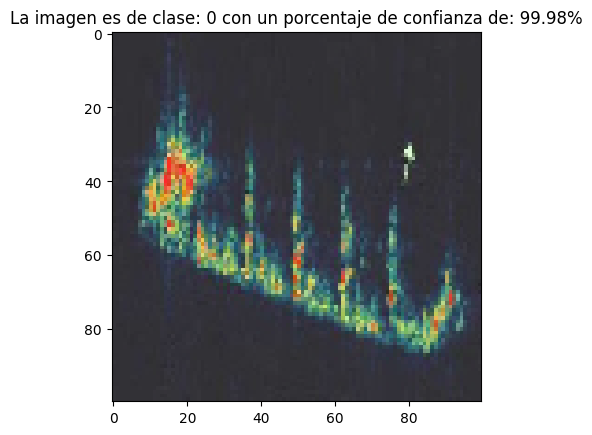


Arreglo de pixeles de la imagen:
 [[ 49  50  50  50  51  53  51  50  50  50  50  50  50  50  50  50  50  50  50  50  52  48  50  53  49  51  52  52  50  49]
 [ 50  50  50  50  51  54  52  50  50  50  50  50  49  51  50  50  50  52  52  52  51  50  50  52  49  50  52  52  50  50]
 [ 50  50  48  49  57  51  51  50  50  50  50  51  51  51  50  50  50  52  51  51  50  51  50  51  51  50  50  51  50  50]
 [ 49  51  50  47  57  60  51  51  49  50  50  51  50  50  50  50  49  50  49  52  50  50  50  48  49  50  52  52  50  50]
 [ 50  51  50  48  55  64  50  52  49  50  51  50  51  50  50  50  50  50  50  51  49  50  50  49  50  50  50  52  50  50]
 [ 48  50  50  51  56  86  54  50  50  50  50  50  50  51  50  50  50  50  50  52  48  49  50  48  50  50  53  53  50  50]
 [ 51  50  50  51  63  89  56  53  50  50  50  50  50  52  50  50  50  50  50  53  51  50  50  48  51  51  50  51  49  50]
 [ 50  49  51  53  72 127  65  54  50  49  50  51  50  52  49  50  50  50  52  53  50  50  50  47  50  5

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

#directorio_imagen_prueba='./prueba/1.jpg'
directorio_imagen_prueba='./datos/mercantes/1.jpg'
# Carga la imagen de prueba
imagen_prueba = cv2.imread(directorio_imagen_prueba)
imagen_prueba = cv2.resize(imagen_prueba, (100, 100))

# OpenCV lee las imágenes en formato BGR, pero los modelos de Keras están entrenados con imágenes en formato RGB, por lo que es necesario convertir la imagen de BGR a RGB
imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)

# Convertir a float32 y normalizar
imagen_prueba = imagen_prueba.astype('float32') / 255.0

# Ajusta las dimensiones de la imagen para que sea compatible con la entrada del modelo
imagen_prueba = np.expand_dims(imagen_prueba, axis=0)

# Obtén las predicciones utilizando el modelo entrenado
predicciones = modelo1.predict(imagen_prueba)

# Las predicciones son un arreglo de probabilidades, conviértelas a una clase
clase_predicha = np.argmax(predicciones[0])

# Obten la clase correspondiente al índice
clase = classes[clase_predicha]

# Obten el porcentaje de confianza para la clase predicha
porcentaje_confianza = predicciones[0][clase_predicha] * 100

# Carga la imagen de nuevo para mostrarla (esta vez en formato RGB para matplotlib)
imagen_prueba = cv2.cvtColor(cv2.imread(directorio_imagen_prueba), cv2.COLOR_BGR2RGB)
imagen_prueba = cv2.resize(imagen_prueba, (100, 100))
imagen_array = np.array(imagen_prueba) # Arreglo de pixeles de la imagen

plt.imshow(imagen_prueba)
plt.title("La imagen es de clase: {} con un porcentaje de confianza de: {:.2f}%".format(clase, porcentaje_confianza))
plt.show()

imagen_prueba1=cv2.resize(imagen_prueba, (30, 30))
imagen_array1=np.array(imagen_prueba1)
# Aproximar los valores de píxeles a la unidad
imagen_pixeles = np.round(color.rgb2gray(imagen_array1) * 255).astype(int)

np.set_printoptions(linewidth=np.inf)
print(f'\nArreglo de pixeles de la imagen:\n {imagen_pixeles}') #Valores entre 0 y 255

In [79]:
def prueba_modelo(modelo, directorio, altura, longitud, classes):
    resultados = []
    for archivo in os.listdir(directorio):
        ruta_imagen = os.path.join(directorio, archivo)
        # Carga la imagen de prueba
        imagen_prueba = cv2.imread(ruta_imagen)
        imagen_prueba = cv2.resize(imagen_prueba, (altura, longitud))

        # OpenCV lee las imágenes en formato BGR, pero los modelos de Keras están entrenados con imágenes en formato RGB, por lo que es necesario convertir la imagen de BGR a RGB
        imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)

        # Convertir a float32 y normalizar
        imagen_prueba = imagen_prueba.astype('float32') / 255.0

        # Ajusta las dimensiones de la imagen para que sea compatible con la entrada del modelo
        imagen_prueba = np.expand_dims(imagen_prueba, axis=0)

        # Obtén las predicciones utilizando el modelo entrenado
        predicciones = modelo.predict(imagen_prueba)

        # Las predicciones son un arreglo de probabilidades, conviértelas a una clase
        clase_predicha = np.argmax(predicciones[0])

        # Obten la clase correspondiente al índice
        clase = classes[clase_predicha]

        resultados.append((archivo, clase))

    return resultados

# Uso de la función prueba_modelo
directorio_imagenes = './prueba'
resultados = prueba_modelo(modelo1, directorio_imagenes, altura, longitud, classes)

# Mostrar resultados
for archivo, clase in resultados:
    print(f"La imagen {archivo} es de clase: {clase}")

1/1 [==============================] - 0s 34ms/step
La imagen 1.jpg es de clase: 0
La imagen 2.png es de clase: 0
La imagen 3.jpg es de clase: 0
La imagen 4.jpg es de clase: 0
La imagen 5.jpg es de clase: 0
La imagen 6.jpg es de clase: 0
La imagen 7.jpg es de clase: 1
La imagen 8.jpg es de clase: 0


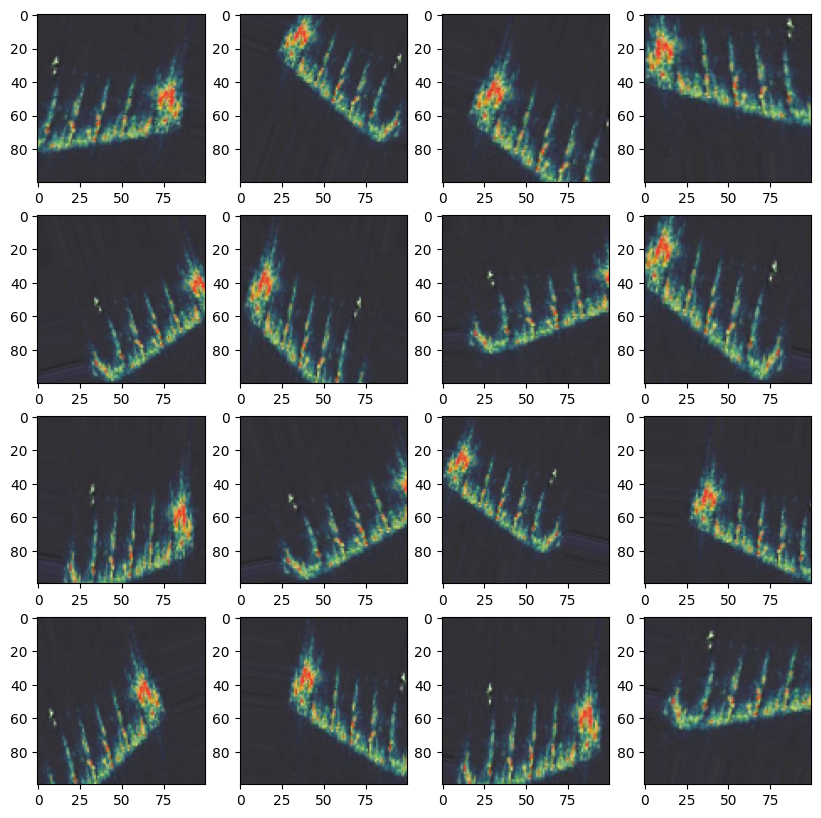

In [80]:
#Loads in image path
img = keras.preprocessing.image.load_img('./datos/mercantes/1.jpg', target_size= (100,100))
img_tensor = keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#Uses ImageDataGenerator to flip the images
datagen = ImageDataGenerator(
    rotation_range=20,         # Rango de rotación aleatoria (en grados)
    width_shift_range=0.2,     # Rango de traslación horizontal aleatoria (como fracción del ancho total)
    height_shift_range=0.2,    # Rango de traslación vertical aleatoria (como fracción del alto total)
    shear_range=0.2,           # Rango de cizallamiento (shear) aleatorio
    zoom_range=0.2,            # Rango de zoom aleatorio
    horizontal_flip=True,      # Volteo horizontal aleatorio
    fill_mode='nearest'        # Modo de rellenado para las transformaciones
)
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(10, 10))
#Plots our figures
for i in range(1,17):
   plt.subplot(4, 4, i)
   batch = pic.next()
   image_ = batch[0].astype('uint8')
   plt.imshow(image_)
plt.show()


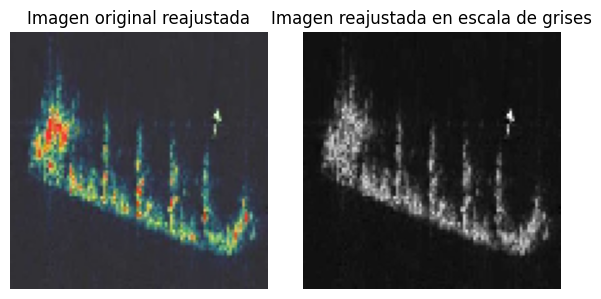

In [81]:
import cv2

# Carga la imagen en color
imagen_color = cv2.imread('./datos/mercantes/1.jpg')
# Reajusta la imagen a 100x100 píxeles
imagen_color_reajustada = cv2.resize(imagen_color, (100, 100))
imagen_gris_reajustada = cv2.cvtColor(imagen_color_reajustada, cv2.COLOR_BGR2GRAY)


plt.figure(figsize=(6, 3))

# Muestra la imagen original reajustada en color
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imagen_color_reajustada, cv2.COLOR_BGR2RGB))
plt.title('Imagen original reajustada')
plt.axis('off')

# Muestra la imagen reajustada en escala de grises
plt.subplot(1, 2, 2)
plt.imshow(imagen_gris_reajustada, cmap='gray')
plt.title('Imagen reajustada en escala de grises')
plt.axis('off')

plt.tight_layout()
plt.show()

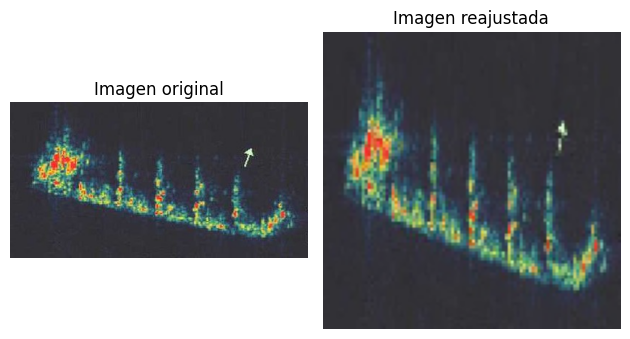

In [82]:
# Carga la imagen original
imagen_original = imagen_color
imagen_original_rgb = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB)

# Tamaño para reajuste
nuevo_ancho = 100
nuevo_alto = 100

# Reajusta la imagen a 100x100 píxeles
imagen_reajustada = cv2.resize(imagen_original_rgb, (nuevo_ancho, nuevo_alto))

# Muestra la imagen original
plt.subplot(1, 2, 1)
plt.imshow(imagen_original_rgb)
plt.title('Imagen original')
plt.axis('off')

# Muestra la imagen reajustada
plt.subplot(1, 2, 2)
plt.imshow(imagen_reajustada)
plt.title('Imagen reajustada')
plt.axis('off')

plt.tight_layout()
plt.show()

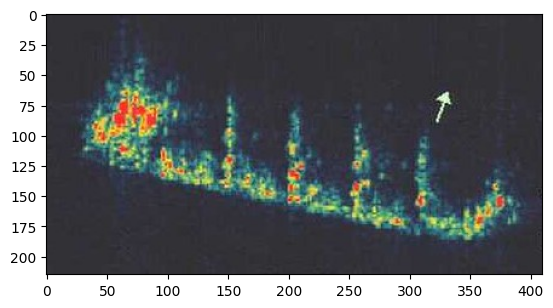

In [83]:
plt.imshow(imagen_original_rgb)